In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt

import neural_tangents as nt
from neural_tangents import stax

from typing import Callable, Optional, Tuple, List, Union

# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

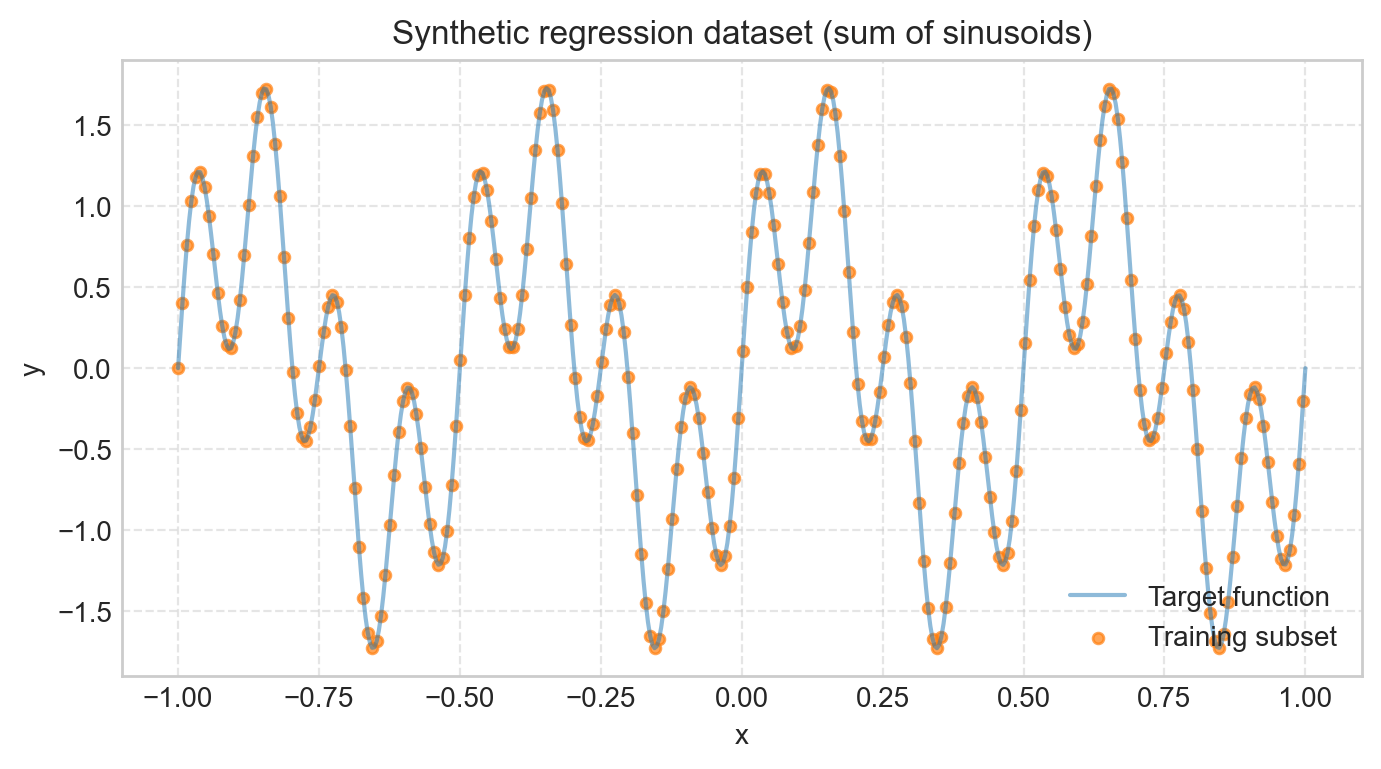

In [2]:
# ----- Data -----
x = jnp.linspace(-1.0, 1.0, 512)[:, None]          # shape [n, 1]
y = (jnp.sin(4*jnp.pi*x) + 0.8*jnp.sin(16*jnp.pi*x)).squeeze()  # shape [n]

# pick a training subset to speed up NTK computations:
idx = jnp.arange(0, x.shape[0], 2)
X_train, y_train = x[idx], y[idx]
X_eval, y_eval = x[~idx], y[~idx]

# visualize full dataset
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Target function', color='C0', alpha=0.5)
plt.scatter(X_train, y_train, color='C1', s=15, alpha=0.7, label='Training subset')
plt.title("Synthetic regression dataset (sum of sinusoids)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [1]:
def create_mlp_stax(
    depth_hidden: int,
    hidden_width: int,
    output_dim: int,
    input_dim: int,
    activation_stax_fn: stax.Relu(),
    W_std: float = 1.0,
    b_std: Optional[float] = 0.0,
    parameterization: str = "ntk",
    W_std_out: Optional[float] = None,
) -> Tuple[Callable, Callable, Callable, List[int]]:
    """
    Build an MLP in neural_tangents.stax.

    Returns:
      init_fn, apply_fn, kernel_fn, widths_list

    Notes:
    - With parameterization='ntk', the *idealized* kernel does not depend on the hidden width.
    - Set b_std=0.0 for no bias; (None is treated as 0.0 here).
    - If you pass a custom callable activation, kernel_fn(get='ntk') may not be available.
    """
    act = activation_stax_fn
    bstd = 0.0 if b_std is None else float(b_std)
    if W_std_out is None:
        W_std_out = W_std

    layers: List[StaxLayer] = []
    widths = [input_dim]

    for _ in range(depth_hidden):
        layers += [
            stax.Dense(hidden_width, W_std=W_std, b_std=bstd, parameterization=parameterization),
            act
        ]
        widths.append(hidden_width)

    layers += [
        stax.Dense(output_dim, W_std=W_std_out, b_std=bstd, parameterization=parameterization)
    ]
    widths.append(output_dim)

    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    return init_fn, apply_fn, kernel_fn, widths

NameError: name 'Tuple' is not defined

In [2]:
# Build: 2 hidden layers, ReLU, no bias
init_fn, apply_fn, kernel_fn, widths = create_mlp_stax(
    depth_hidden=1, hidden_width=1024, output_dim=1, input_dim=1,
    activation_stax_fn="relu", 
    b_std=0.0,                       # no bias
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

# Finite net params
key = jax.random.PRNGKey(0)
_, params0 = init_fn(key, (-1, 1))  # input shape (-1, input_dim)

NameError: name 'create_mlp_stax' is not defined

In [5]:
# ---------- Empirical NTK via Neural Tangents ----------
# f(params, x) must map [batch, d] -> [batch, 1] here
f = lambda p, x: apply_fn(p, x)

# trace_axes=() because the output is scalar per example (no output dim to trace over)
# vmap_axes=0 says the first axis is the batch axis.
emp_ntk_fn = nt.empirical_ntk_fn(f, trace_axes=(), vmap_axes=0)

# Initial empirical NTK on training set
K0 = emp_ntk_fn(X_train, None, params0)            # shape [N, N]

# Linearized kernel regression coefficients at init (ridge for stability)
lam = 1e-6
eyeN = jnp.eye(K0.shape[0], dtype=K0.dtype)
alpha0 = jnp.linalg.solve(K0 + lam * eyeN, y_train)  # [N]


In [7]:
# ---------- Training pieces ----------
def mse(params, x, y):
    y_hat = apply_fn(params, x)
    return jnp.mean((y_hat - y) ** 2)

opt = optax.adam(1e-3)

@jit
def train_step(params, opt_state, x, y):
    jax.debug.callback(lambda : print("Inside"))
    loss, grads = value_and_grad(mse)(params, x, y)
    jax.debug.callback(lambda loss: print(f"{loss=}", loss))
    updates, opt_state = opt.update(grads, opt_state, params)
    jax.debug.callback(lambda: print("After loss step"))
    params = optax.apply_updates(params, updates)
    jax.debug.callback(lambda: print("exiting"))
    return params, opt_state, loss

# Flatten helpers for parameter drift
def flatten_params(p): return ravel_pytree(p)[0]
theta0 = flatten_params(params0)
norm_K0 = jnp.linalg.norm(K0)

In [8]:
# ---------- Train + log metrics ----------
num_steps = 3000
log_every = 10
opt_state = opt.init(params0)
params = params0


In [ ]:
for step in range(1, num_steps + 1):
    params, opt_state, loss = train_step(params, opt_state, X_train, y_train)

    # if step % log_every == 0 or step == 1:
    #     # Kernel drift ||K_t - K_0||_F / ||K_0||_F
    #     Kt = emp_ntk_fn(X_train, None, params)
    #     ker_dr = jnp.linalg.norm(Kt - K0) / (norm_K0 + 1e-12)

    #     # Parameter drift ||θ_t - θ_0|| / ||θ_0||
    #     thetat = flatten_params(params)
    #     par_dr = jnp.linalg.norm(thetat - theta0) / (jnp.linalg.norm(theta0) + 1e-12)

    #     # Linearization gap between the network and the init-NTK linearized predictor
    #     y_net = apply_fn(params, X_eval).squeeze(-1)
    #     y_lin = predict_linearized(params0, X_eval).squeeze(-1)
    #     lin_gap = jnp.linalg.norm(y_net - y_lin) / (jnp.linalg.norm(y_net) + 1e-12)

    #     print(f"step {step:4d} | loss {loss:.3e} | K-drift {ker_dr:.3e} | θ-drift {par_dr:.3e} | lin-gap {lin_gap:.3e}")

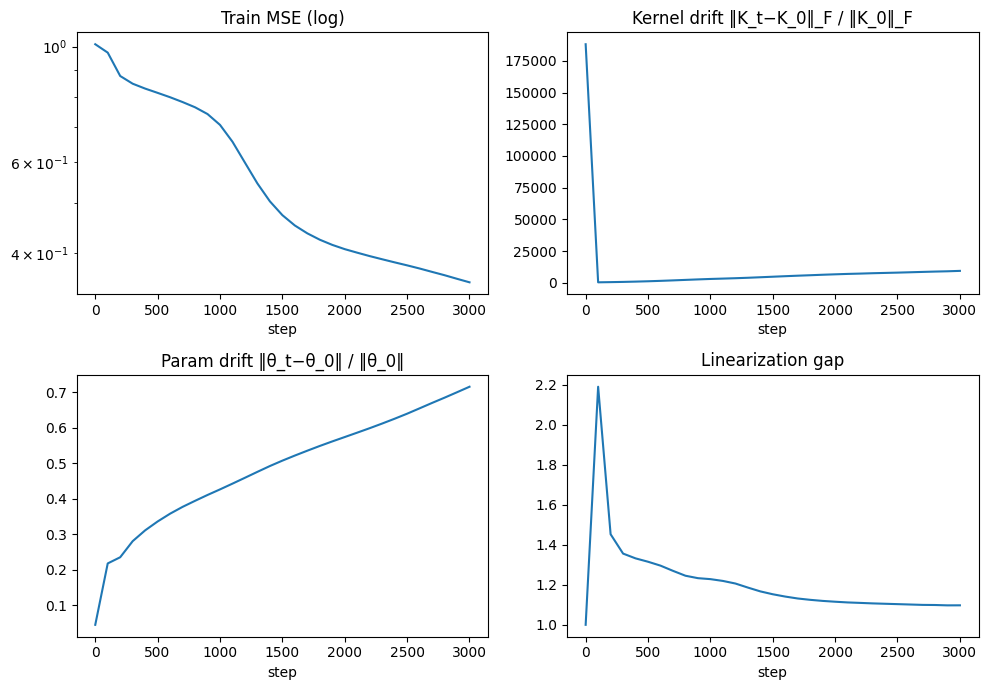

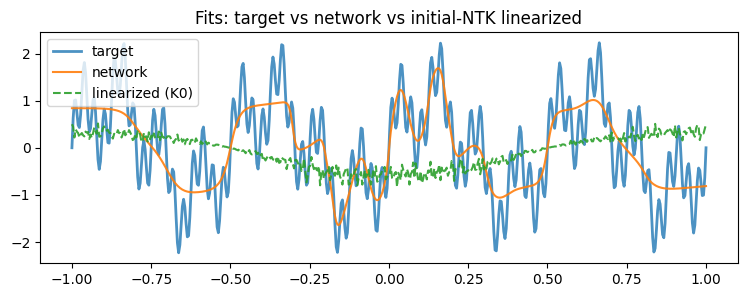

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
axs = axs.ravel()

axs[0].set_title("Train MSE (log)")
axs[0].plot(jnp.arange(len(losses))*log_every + 1, jnp.array(losses))
axs[0].set_yscale('log'); axs[0].set_xlabel("step")

axs[1].set_title("Kernel drift ‖K_t−K_0‖_F / ‖K_0‖_F")
axs[1].plot(jnp.arange(len(ker_drifts))*log_every + 1, jnp.array(ker_drifts))
axs[1].set_xlabel("step")

axs[2].set_title("Param drift ‖θ_t−θ_0‖ / ‖θ_0‖")
axs[2].plot(jnp.arange(len(par_drifts))*log_every + 1, jnp.array(par_drifts))
axs[2].set_xlabel("step")

axs[3].set_title("Linearization gap")
axs[3].plot(jnp.arange(len(lin_gaps))*log_every + 1, jnp.array(lin_gaps))
axs[3].set_xlabel("step")
plt.tight_layout()
plt.show()

# Compare final fits on dense grid
y_net = preds(params, x).reshape(-1)
y_lin = predict_kernel(params0, x)

plt.figure(figsize=(9,3))
plt.plot(x.squeeze(), y, label='target', linewidth=2, alpha=0.8)
plt.plot(x.squeeze(), y_net, label='network', alpha=0.9)
plt.plot(x.squeeze(), y_lin, label='linearized (K0)', alpha=0.9, linestyle='--')
plt.legend(); plt.title("Fits: target vs network vs initial-NTK linearized"); plt.show()
